# Comparing contextual vectors

In [ ]:
#pip install torch transformers datasets bertviz seaborn scikit-learn

In [1]:
import numpy as np
import datasets
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt
from bertviz import model_view, head_view

So far, we have been working with *static* word (or sequence) embeddings.   
Word2vec is an example of static word embeddings – it has a set vocabulary, where each word has a single embedding that is the same no matter the case.

But as we know, words can take on different meanings depending on their context. 
Contextualized embeddings aim to learn something about the semantics of the whole sequence. Practically, contextualized embeddings, like those produced by Transformer models, generate different embeddings for the same word based on its surrounding context. 

It should be possible to capture the difference between "bank" in "river bank" vs. "bank loan". 

One of the mechanisms that allows this is attention.
Let's start seeing if we can recreate the example from lecture: `"The cat sat on the mat"` with a real model.

In [3]:
sentence = "The cat sat on the mat"

In [52]:
# Load a small pretrained transformer model to extract embeddings and attention
model_name = "prajjwal1/bert-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(
    model_name, output_attentions=True, attn_implementation="eager")

In [53]:
# Tokenize
inputs = tokenizer(sentence, return_tensors='pt')
inputs

{'input_ids': tensor([[  101,  1996,   103,  2938,  2006,  1996, 13523,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [54]:
# Run inference
with torch.no_grad():
    outputs = model(**inputs)

In [55]:
# Extract embeddings (last hidden state) and attention from the model
embeddings = outputs.last_hidden_state  
attentions = outputs.attentions  

# Decode tokens for visualization
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

In [58]:
embeddings

tensor([[[ 0.7212,  0.5787, -1.0313,  ..., -1.6697,  0.5990,  0.8985],
         [-0.0714,  0.4048, -1.8652,  ..., -0.9494, -0.0748,  0.5646],
         [-0.3783,  0.1252, -0.7728,  ...,  0.3208,  0.5755,  0.2182],
         ...,
         [ 0.7428,  0.5714, -1.6554,  ..., -2.4508,  0.3485,  0.3064],
         [ 0.6877,  1.0608, -0.4515,  ..., -0.8734,  0.9496,  0.1578],
         [ 1.0787,  0.3202, -0.4848,  ..., -1.5966,  0.5675,  1.4659]]])

In [ ]:
# embeddings are a tensor shape (batch_size, sequence_length, embedding_size)
embeddings.shape

In [59]:
# attentions is a tuple of tenros...
[
    type(attentions),
    len(attentions)
]


[tuple, 4]

In [60]:
# ...where each layer has (batch_size, num_heads, sequence_length, sequence_length)
attentions[0].shape

torch.Size([1, 8, 8, 8])

Let's see how that looks visualized.

This specific model has just 4 layers of attention (this is actually quite low). 
 
And 8 attention heads. This number has nothing to do with the specific sentence (which is 8 tokens long), but instead, this is decided by the model's architecture;
  

In [61]:
head_view(attentions, tokens)

<IPython.core.display.Javascript object>

Or you can plot each attention head separately:

In [ ]:
# Attention from the first layer, first head
L1H1 = attentions[0][0, 0]

# Plot attention weights for the CLS token (attention_scores[0] gives weights from CLS to all tokens)
plt.figure(figsize=(10, 6))
sns.heatmap(L1H1, annot=True, xticklabels=tokens, yticklabels=tokens, cmap='Blues')
plt.show()

In [ ]:
# plot all attention heads in the model
model_view(attentions, tokens)

Relevant at this point (but will be on the readings later):

- [CLS] is a special token added at the beginning of each sequence. It means “classification” and should contain some information representing the whole sequence.
- [SEP] is a special token used to separate two sequences in tasks like question answering or sentence pair classification. It also marks the end of a single sequence when only one is provided.

These special tokens are specific to the BERT architecture (Devlin et al., 2019)

Now, what do there connection mean?

1. which attention heads are covering the words that attend to themselves?
2. which heads are capturing the order of words in the sentence?
3. which heads are telling the [CLS] token what is important in the sentence?

### Comparing embeddings – Projections
Let's try to project the embeddings using dimensionality reduction to get more insight into how meaning is represented in our model.  
Dimensionality reduction aims to transform high dimensional data to a lower number of dimensions, while preserving some characteristics of the original data.  
For example, our contextual embeddings are 512-dimensional, which makes them difficult to visualize. We can use PCA to reduce them to 2 dimensions for visualization.  
When reducing dimensions, we aim to "keep the gist" of the data, while we have to count with losing some granularity (2-dim projections are never going to be as fine-grained as the 512-dim originals).


For more on Principal Component Analysis (PCA), you can check out the [sklearn's documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
or skim this short [Nature article](https://www.nature.com/articles/nmeth.4346).

Alternative methods are: [UMAP](https://pair-code.github.io/understanding-umap/) and [t-SNE](https://distill.pub/2016/misread-tsne/).

You don't have to understand the inner workings of these dimensionality reduction methods for this course.  
It's just good to know they are there, because they are very useful.

In [ ]:
embeddings = embeddings.squeeze(0)  # Remove the batch dimension

# Apply PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings.cpu().numpy())

# Plot the 2D projection of BERT embeddings
plt.figure(figsize=(10, 8))
for i, token in enumerate(tokens):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], marker='x', color='blue')
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], token, fontsize=12)


Notice where the embeddings landed.
What is happening here?

What characteristic do the outlier words share?  
What kind of words are close to the [CLS], central token?

### Paraphrasing – distance between sentences

The goal of the model is to embed similar sentences close to each other in the embedding space. 
A nice case for this is paraphrasing – saying (almost) the same thing using different words. 
If a model is able to detect paraphrases, this is a good indication of its performance.

So, our goal is to test whether the model understands that 
`"In 1995, the last survey, those numbers were equal."` is equivalent to `"The last time the survey was conducted, in 1995, those numbers matched."`

To do that, we will measure distance between embeddings of the two sentences.
We have to implement a distance metric first.

In [87]:
# Implement a cosine similarity in any way
def cosine_similarity(A, B) -> float:
    """
    Dot product of two vectors divided by the product of their norms (magnitudes)
    """
    return torch.dot(A, B) / (torch.norm(A) * torch.norm(B))

# test if it works
testing_results = cosine_similarity(
    A = torch.Tensor([0.5, 0.2, 0.7]),
    B = torch.Tensor([0.2, 0.1, 0.5])
    )

assert np.isclose(testing_results, 0.9716)

In [6]:
# Implement a function for extracting embeddings
def infer_embedding(sentence: str) -> torch.Tensor:
    """
    """
    # tokenize, remember to `return_tensors="pt"`
    inputs = tokenizer(sentence, return_tensors='pt', padding=True)

    # inference (passing the input_ids through the model)
    with torch.no_grad():
        outputs = model(**inputs)

    # squeeze the last hidden state and return it
    return outputs.last_hidden_state.squeeze()

assert infer_embedding("test test test").shape == (5, 512)

In [7]:
original_sent = "In 1995, the last survey, those numbers were equal."
paraphrased_sent = "The last time the survey was conducted, in 1995, those numbers matched."

In [62]:
# run the little test
emb_orig_sent = infer_embedding(original_sent)
emb_para_sent = infer_embedding(paraphrased_sent)

cls_orig_sent = emb_orig_sent[0, :]
cls_para_sent = emb_para_sent[0, :]

# shape of emb_orig_sent is (tokens, activations).
# We want an average embedding for the whole sentence, 
# which means we should end with just one and 512 columns
# = average the tokens = `dim=0` in this case.
mean_orig_sent = torch.mean(emb_orig_sent, dim=0)
mean_para_sent = torch.mean(emb_para_sent, dim=0)

# .max() works a bit differently in torch!
# the output is a tuple; 
# max_orig_sent[0] is maximum value per row
# max_orig_sent[1] is the index of this value in within its original row in emb_orig_sent
# we want just the maximum value, so we add the `[0]` right away.
max_orig_sent = torch.max(emb_orig_sent, dim=0)[0]
max_para_sent = torch.max(emb_para_sent, dim=0)[0]

print(f"Cosine similarity (CLS token): {cosine_similarity(cls_orig_sent, cls_para_sent)}")
print(f"Cosine similarity (Mean pooling): {cosine_similarity(mean_orig_sent, mean_para_sent)}")
print(f"Cosine similarity (Max): {cosine_similarity(max_orig_sent, max_para_sent)}")

Cosine similarity (CLS token): 0.8661871552467346
Cosine similarity (Mean pooling): 0.8752886652946472
Cosine similarity (Max): 0.9387845993041992


Thoughts?  
Do the similarities indicate that the sentences are paraphrased?  

Let's see how representative the different measures are in a projection:

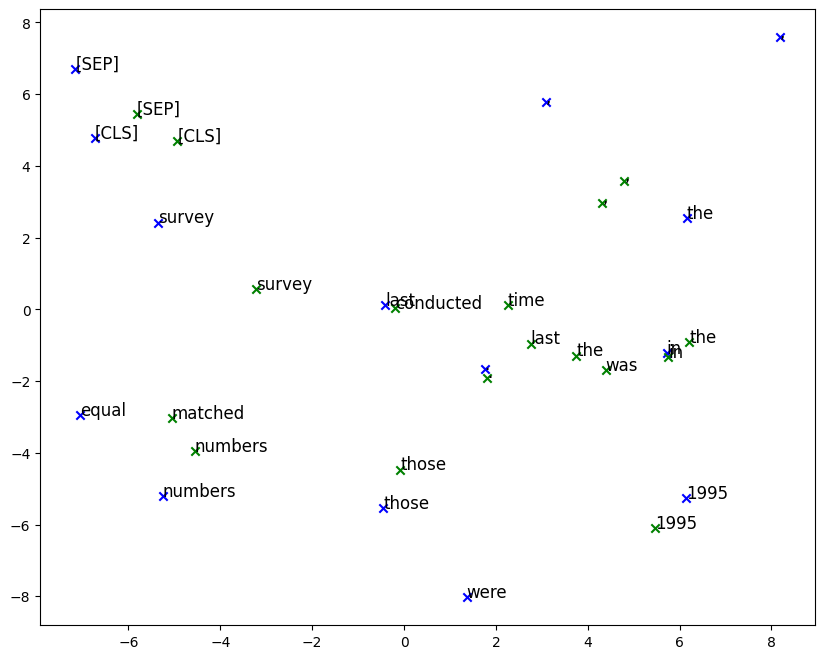

In [9]:
# dimensionality reduction
pca = PCA(n_components=2)
# fit on the first embedding only 
# with more data, you would fit on the whole train set
emb_orig_2d = pca.fit_transform(emb_orig_sent)
# transform on the second embedding to ese how they align
# with more data, you would transform on the whole test set
emb_para_2d = pca.transform(emb_para_sent)

# we have to repeat tokenization, to get the token text
ip_orig = tokenizer(original_sent, return_tensors="pt")
ip_para = tokenizer(paraphrased_sent, return_tensors="pt")
tok_orig = tokenizer.convert_ids_to_tokens(ip_orig['input_ids'][0])
tok_pare = tokenizer.convert_ids_to_tokens(ip_para['input_ids'][0])

plt.figure(figsize=(10, 8))
for i, token in enumerate(tok_orig):
    plt.scatter(emb_orig_2d[i, 0], emb_orig_2d[i, 1], marker='x', color='blue')
    plt.text(emb_orig_2d[i, 0], emb_orig_2d[i, 1], s=token, fontsize=12)

for i, token in enumerate(tok_pare):    
    plt.scatter(emb_para_2d[i, 0], emb_para_2d[i, 1], marker='x', color='green')
    plt.text(emb_para_2d[i, 0], emb_para_2d[i, 1], s=token, fontsize=12)

### First taste of masked learning

Attention is also used for guessing a missing word in a sequence.  
It tells the model which words to care about more.

This is just a teaser, more on this in the next two weeks!

In [10]:
# masked attention
# 1. Define the sentence
sentence = "The [MASK] sat on the mat"

# 2. Load a pretrained BERT tokenizer and model for embedding generation
model_name = "prajjwal1/bert-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True)

# 3. Tokenize the sentence
inputs = tokenizer(sentence, return_tensors='pt')

# 4. Generate embeddings and attention weights using BERT
with torch.no_grad():
    outputs = model(**inputs)

# Extract hidden states (embeddings) and attention from the model
hidden_states = outputs.hidden_states  # (layer, batch, seq_len, hidden_size)
attentions = outputs.attentions  # (layer, batch, num_heads, seq_len, seq_len)

# Convert token IDs back to tokens for visualization
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

head_view(attentions, tokens)

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


<IPython.core.display.Javascript object>

In [ ]:
from transformers import pipeline

unmasker = pipeline('fill-mask', model=model_name)
unmasker("The [MASK] sat on the mat")

# STS (Semantic Textual Similarity) experiment


Problem:  
We want to evaluate a model's capabilties to understand semantic similarity.  
And, we want to use many more sentence pairs for this task, so that we can draw some conclusions.

Method:
- find a task for the model to do (dataset with labels)
- embed the texts
- calculate similarity between sentence pairs
- compare gold standard labels (similarity scores between the sentences, annotated by humans) and the models predictions (cosine similarity between sentence pairs)

For this, I've already found a dataset: [stsb_multi_mt](https://huggingface.co/datasets/mteb/stsb_multi_mt).  
This dataset provides pairs of sentences and a score of their similarity.  
Here is a table explaining the different possible similarity scores.

score | 2 example sentences | explanation
------|---------|------------
5 | *The bird is bathing in the sink.<br/>Birdie is washing itself in the water basin.* | The two sentences are completely equivalent, as they mean the same thing.
4 | *Two boys on a couch are playing video games.<br/>Two boys are playing a video game.* | The two sentences are mostly equivalent, but some unimportant details differ.
3 | *John said he is considered a witness but not a suspect.<br/>“He is not a suspect anymore.” John said.* | The two sentences are roughly equivalent, but some important information differs/missing.
2 | *They flew out of the nest in groups.<br/>They flew into the nest together.* | The two sentences are not equivalent, but share some details.
1 | *The woman is playing the violin.<br/>The young lady enjoys listening to the guitar.* | The two sentences are not equivalent, but are on the same topic.
0 | *The black dog is running through the snow.<br/>A race car driver is driving his car through the mud.* | The two sentences are completely dissimilar.


Check out the [dataset card](https://huggingface.co/datasets/mteb/stsb_multi_mt) on huggingface for more info about how the dataset was created & anything else that is good to know when you want to make claims based on the dataset.  

Unfortunately, the link to the original dataset is dead.  
But, with a little digging, it's possible to uncover some helpful [insight](https://github.com/embeddings-benchmark/mteb/blob/main/mteb/tasks/STS/multilingual/STSBenchmarkMultilingualSTS.py) about what kind of texts there are in the dataset.

Let's load it and get started.

In [70]:
# load in the "mteb/stsb_multi_mt" dataset, only the English part of it (name="en") & only the test split.
# we aren't going to train the models, just evaluate how much they have learned so far.
raw_pairs = datasets.load_dataset("mteb/stsb_multi_mt", name="en", split="test")
# this is how one observation looks
raw_pairs[0]

{'sentence1': 'A girl is styling her hair.',
 'sentence2': 'A girl is brushing her hair.',
 'similarity_score': 2.5,
 'lang': 'en'}

Now, let's get to know the dataset just a bit.  
We can check the distribution of similarity scores, this will allow us to catch problems early.  

A problem would be, for example, a huge imbalance between the scores: most observations being rated 5, while only a small fraction has different scores.  
Is there a problem?

2.6079166059890806

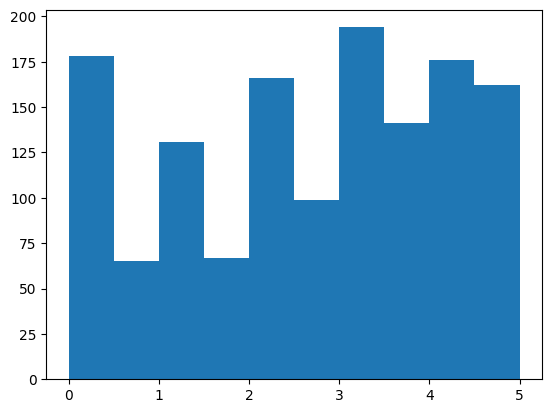

In [20]:
# check the distribution of similarity scores
# e.g. by plotting a histogram
from statistics import mean

plt.hist(raw_pairs['similarity_score'])
mean(raw_pairs['similarity_score'])

Another question is, do we really need all the data?  
Our current dataset is not very big, so we can just use everything.  
In case you'd be evaluating millions of sentence pairs though, it's preferable to take just a sample.  
This is how you would do that in `datasets`:

In [25]:
sample_raw_pairs = raw_pairs.train_test_split(
    test_size=600,                  # also available as `train_size=779`, or as a percentage `test_size=0.2`
    shuffle=True,                   # good idea to shuffle for evaluations
    seed=42,                        # always set a random seed when sampling, so you can reproduce results
    # stratify_by_column="label"    # in case your dataset has class labels, like POSITIVE or NEGATGIVE, this is how you ensure that they are similarly represened in both train and test sets
).get("test")

In [ ]:
# let's check if the distribution of similarity scores has changed very much
# TODO

Defining a new inference function

In [76]:
def infer_cls_token(model_name, texts) -> torch.Tensor:
    """Infers the [CLS] embedding from texts.

    Parameters
    ----------
    model_name : str
        a valid huggingface model name in a {user}/{model} format
    
    texts : str|iterable
        str in case of a single text
        list[str] or any other iterable for multiple texts
    
    Returns
    -------
    torch.Tensor
        [CLS] embedding(s) of the sequence(s)
        of shape (n_documents, n_features)
    """
    # load tokenizer and model 
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name, output_attentions=True, attn_implementation="eager")

    # tokenize the sequence
    inputs = tokenizer(texts, return_tensors="pt", padding=True)

    # infer the embedding
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.squeeze()
    
    # extract the CLS token (which always comes first)
    cls_embeddings = embeddings[:,0,]

    return cls_embeddings

In [82]:
# Infer two sets of embeddings, 1) for raw_pairs["sentence1"] & 2) for raw_pairs["sentence2"]
cls_embeddings_s1 = infer_cls_token(texts=raw_pairs["sentence1"], model_name="prajjwal1/bert-small")
cls_embeddings_s2 = infer_cls_token(texts=raw_pairs["sentence2"], model_name="prajjwal1/bert-small")

Now we calculate cosine similarity between each pair of embeddings.  
That means: `similarity(cls_embeddings_s1[i], cls_embeddings_s2[i])`.

Hint: there are several options,
1. use the cosine similarity function we coded in class (in a for loop where you iterate through embeddings in both cls_embeddings_s1 and cls_embeddings_s2 – our function can only handle single vectors).
2. use a pre-made implementation, e.g. from sklearn that can process a whole embedding matrix.

Rembeber, `cosine_similarity = 1 - cosine_distance`.

In [101]:
cos_sim = []
for i in range(len(cls_embeddings_s1)):
    cos_sim.append(float(cosine_similarity(cls_embeddings_s1[i], cls_embeddings_s2[i])))

Now, let's measure how much the model is in agreement with the annotators, who created the similarity scores.  

We could use spearman correlation for this.  
Additionally, we can also plot it. 

SignificanceResult(statistic=np.float64(0.4307682974353474), pvalue=np.float64(2.1027094982878427e-63))


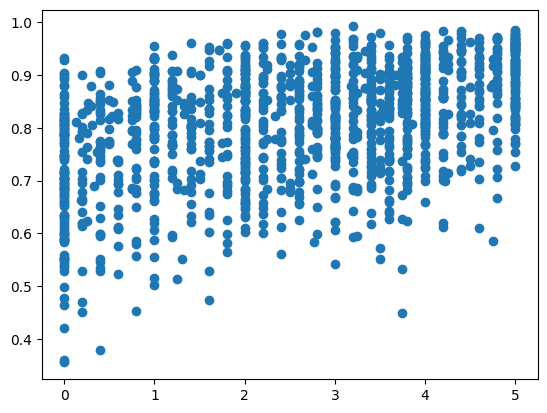

In [105]:
# Do a spearman correlation 
# hint: scipy
from scipy.stats import spearmanr

print(spearmanr(raw_pairs['similarity_score'], cos_sim))
plt.scatter(raw_pairs['similarity_score'], cos_sim)

Are they in agreement?  
Did you expect more or less agreement?  
What does this tell us about the model?

**Bonus**:  
Redo the experiment with mean or max pooling instead and compare results.  

In [31]:
def infer_with_mean_pooling():
    pass

**Hardcore bonus**:

To generalize the mean pooling for other models and metrics, we need to make some adjustments to the mean pooling function.

Namely, we need to ignore padding tokens.  
The problem arises from sequences having different lengths:

In [ ]:
# hello has 3 tokens
tokenizer("hello")

In [ ]:
# hello has 3 tokens
# hello there has 4 tokens
# this will throw errors if we try to pass it through the model (see next block)
tokenizer(["hello", "hello there"])

In [34]:
# this code will raise an error

# inputs = tokenizer(["hello", "hello there"], return_tensors="pt")
# with torch.no_grad():
#     outputs = model(**inputs)

In [ ]:
# solution: turn on padding
# this means, add a padding token to the end of a shorter sequence, so that all inputs are the same length

tokenizer(["hello", "hello there"], padding=True)

Now the `attention_mask` is going to come in handy!  
The attention mask is a vector of 0s and 1s that indicates which tokens are real and which are padding. 

In [ ]:
tokenizer(["hello", "hello there"], padding=True)["attention_mask"]

We want to ignore the padding tokens when computing the mean.  

This is not very straightforward, so I suggest you find how to do that in this [excellent tutorial](https://osanseviero.github.io/hackerllama/blog/posts/sentence_embeddings/).  
Search for "Modify the pooling so we take the attention mask into account" in the tutorial.  

In [37]:
# rerun the experiment with an adjusted mean pooling function
def mean_pooling():
    pass

def infer_with_padding_adjusted_mean_pooling():
    pass


# In this case, we should actually get the same result as with naive mean pooling. 
# This won't always be the case.